# Basic Imports

In [1]:
import os
import sys
import torch
import importlib
import numpy as np
from omegaconf import OmegaConf
from taming.models import vqgan 
import numpy as np 
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.util import *
import torch.nn as nn
import matplotlib.pyplot as plt

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
def instantiate_from_config(config):
    if not "target" in config:
        if config == '__is_first_stage__':
            return None
        elif config == "__is_unconditional__":
            return None
        raise KeyError("Expected key `target` to instantiate.")
    return get_obj_from_str(config["target"])(**config.get("params", dict()))

def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt)#, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.cuda()
    model.eval()
    return model


def get_model(teacher=True):
    config = OmegaConf.load(f"{cwd}/cin256-v2-custom.yaml")  
    if teacher == True:
        model = load_model_from_config(config, f"{cwd}/model_teacher.ckpt")
    else:
        model = load_model_from_config(config, f"{cwd}/model_student.ckpt")
    return model

In [3]:
# teacher = get_model()
# sampler_teacher = DDIMSampler(teacher)

## WITHOUT UPDATES!

In [4]:
# NUM_CLASSES = 1000
# inst_per_distil = 1
# ddim_steps = 10
# ddim_eta = 0.0
# scale = 3.0

# all_samples = list()

# with torch.no_grad():
#         for run in range(inst_per_distil):
#                 with model.ema_scope():
#                         uc = model.get_learned_conditioning(
#                                 {model.cond_stage_key: torch.tensor(1*[1000]).to(model.device)}
#                                 )
#                         for class_prompt in torch.randint(0, NUM_CLASSES, (inst_per_distil,)):
#                                 xc = torch.tensor(1*[class_prompt])
#                                 c = model.get_learned_conditioning({model.cond_stage_key: xc.to(model.device)})
                                
#                                 samples_ddim, _ = sampler.sample(S=ddim_steps,
#                                                                 conditioning=c,
#                                                                 batch_size=1,
#                                                                 shape=[3, 64, 64],
#                                                                 verbose=False,
#                                                                 unconditional_guidance_scale=scale,
#                                                                 unconditional_conditioning=uc, 
#                                                                 eta=ddim_eta,
#                                                                 keep_intermediates=True,
#                                                                 test=True,
#                                                                 intermediate_step=None,
#                                                                 total_steps=None)
                                
# # display as grid
# x_samples_ddim = model.decode_first_stage(_["x_inter"][-1])
# x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, 
#                             min=0.0, max=1.0)


# grid = rearrange(x_samples_ddim, 'b c h w -> (b) c h w')
# grid = make_grid(grid, nrow=1)

# # to image
# grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
# Image.fromarray(grid.astype(np.uint8))

# WITH UPDATES!

In [5]:
# NUM_CLASSES = 1000
# inst_per_distil = 1
# ddim_steps = 10
# ddim_eta = 0.0
# scale = 3.0

# updates = int(ddim_steps / 2)

# all_samples = list()

# with torch.no_grad():
#         for run in range(inst_per_distil):
#                 with model.ema_scope():
#                         uc = model.get_learned_conditioning(
#                                 {model.cond_stage_key: torch.tensor(1*[1000]).to(model.device)}
#                                 )
#                         for class_prompt in torch.randint(0, NUM_CLASSES, (inst_per_distil,)):
#                                 sampler.make_schedule(ddim_num_steps=ddim_steps, ddim_eta=ddim_eta, verbose=False)
#                                 xc = torch.tensor([class_prompt])
#                                 c = model.get_learned_conditioning({model.cond_stage_key: xc.to(model.device)})
#                                 x_T = None
#                                 for steps in range(updates):
#                                         samples_ddim, _ = sampler.sample(S=2,
#                                                                         conditioning=c,
#                                                                         batch_size=1,
#                                                                         shape=[3, 64, 64],
#                                                                         verbose=False,
#                                                                         x_T=x_T,
#                                                                         unconditional_guidance_scale=scale,
#                                                                         unconditional_conditioning=uc, 
#                                                                         eta=ddim_eta,
#                                                                         keep_intermediates=True,
#                                                                         intermediate_step = steps*2,
#                                                                         steps_per_sampling = 2,
#                                                                         total_steps = ddim_steps)
#                                         x_T = _["x_inter"][-1]


# x_samples_ddim = model.decode_first_stage(_["x_inter"][-1])
# x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)
# grid = rearrange(x_samples_ddim, 'b c h w -> (b) c h w')
# grid = make_grid(grid, nrow=1)
# grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
# Image.fromarray(grid.astype(np.uint8)) 

# With Updates and student Loss!

In [6]:
import copy
# teacher = get_model(teacher=True)
# sampler_teacher = DDIMSampler(teacher)
# student = get_model(teacher=False)
# student.requires_grad = True
# sampler_student = DDIMSampler(student)

teacher = get_model(teacher=True)
sampler_teacher = DDIMSampler(teacher)
student = copy.deepcopy(teacher)
student.requires_grad = True
sampler_student = DDIMSampler(student)

for param in sampler_student.model.parameters():
    param.requires_grad = True

for param in student.model.parameters():
    param.requires_grad = True

sampler_student.model.requires_grad = True
student.model.requires_grad = True


# state_teacher = teacher.state_dict().__str__()
# state_student = student.state_dict().__str__()

# print("teacher equals student:", state_teacher == state_student)

# del state_teacher
# del state_student

In [7]:
def mse_loss(teacher, student):
    [b, c, h, w] = teacher.shape
    size = c * h * w
    teacher = teacher.flatten()
    student = student.flatten()
    return torch.sum((teacher - student) ** 2) / size

MSEloss = nn.MSELoss()
# torch.set_grad_enabled(True)
    

In [8]:
NUM_CLASSES = 1000
inst_per_distil = 1
generations = 1
ddim_steps_teacher = 10
ddim_steps_student = int(ddim_steps_teacher / 2)
TEACHER_STEPS = 2
STUDENT_STEPS = 1
ddim_eta = 0.0
scale = 3.0

updates = int(ddim_steps_teacher / TEACHER_STEPS)

all_samples = list()
averaged_losses = []

teacher_samples = list()
student_samples = list()



# optimizer = torch.optim.Adam(sampler_student.model.parameters(), lr=0.1, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
optimizer = torch.optim.SGD(sampler_student.model.parameters(), lr=0.0001, momentum=0.9)


with torch.no_grad():
        for run in range(inst_per_distil):
                print("RUN: ", run, end=" | ")
                with teacher.ema_scope():
                        uc = teacher.get_learned_conditioning(
                                {teacher.cond_stage_key: torch.tensor(1*[1000]).to(teacher.device)}
                                )
                        for class_prompt in torch.randint(0, NUM_CLASSES, (generations,)):
                                losses = []
                        # for class_prompt in [1]:
                                sampler_teacher.make_schedule(ddim_num_steps=ddim_steps_teacher, ddim_eta=ddim_eta, verbose=False)
                                xc = torch.tensor([class_prompt])
                                c = teacher.get_learned_conditioning({teacher.cond_stage_key: xc.to(teacher.device)})
                                x_T = None
                                # optimizer.zero_grad()
                                sampler_student.make_schedule(ddim_num_steps=ddim_steps_student, ddim_eta=ddim_eta, verbose=False)
                                c_student = student.get_learned_conditioning({student.cond_stage_key: xc.to(student.device)})
                                for steps in range(updates):
                                        
                                        # with torch.no_grad():
                                        print("step:", steps)
                                        
                                        samples_ddim, teacher_intermediate, x_T_copy = sampler_teacher.sample(S=TEACHER_STEPS,
                                                                        conditioning=c,
                                                                        batch_size=1,
                                                                        shape=[3, 64, 64],
                                                                        verbose=False,
                                                                        x_T=x_T,
                                                                        unconditional_guidance_scale=scale,
                                                                        unconditional_conditioning=uc, 
                                                                        eta=ddim_eta,
                                                                        keep_intermediates=True,
                                                                        intermediate_step = steps*TEACHER_STEPS,
                                                                        steps_per_sampling = TEACHER_STEPS,
                                                                        total_steps = ddim_steps_teacher)
                                        x_T = teacher_intermediate["x_inter"][-1]

                                        with torch.enable_grad():
                                                
                                                if steps == 0:
                                                        
                                                        x_T_student = copy.deepcopy(x_T_copy)
                                                        x_T_student.requires_grad = True
                                                        
                                                optimizer.zero_grad()
                                                samples_ddim_student, student_intermediate, x_T_copy = sampler_student.sample_student(S=STUDENT_STEPS,
                                                                                conditioning=c_student,
                                                                                batch_size=1,
                                                                                shape=[3, 64, 64],
                                                                                verbose=False,
                                                                                x_T=x_T,
                                                                                unconditional_guidance_scale=scale,
                                                                                unconditional_conditioning=uc, 
                                                                                eta=ddim_eta,
                                                                                keep_intermediates=True,
                                                                                intermediate_step = steps*STUDENT_STEPS,
                                                                                steps_per_sampling = STUDENT_STEPS,
                                                                                total_steps = ddim_steps_student)
                                                
                                                x_T_student = student_intermediate["x_inter"][-1]
                                        
                                                
                                                
                                                
                                                # x_T_student.requires_grad = True
                                                # loss = mse_loss(x_T_student, x_T)
                                                loss = MSEloss(x_T_student, x_T)
                                                # loss = MSEloss(samples_ddim_student.flatten(), samples_ddim.flatten())
                                                
                                                print("Loss:", round(loss.item(), 5), end= " | ")
                                                print("loss", loss)
                                                print("backward!")
                                                loss.backward()
                                                
                                                optimizer.step()
                                                
                                                losses.append(loss.item())
                                                # optimizer.zero_grad()
                                
                                        

                        print("Loss: ", round(sum(losses) / len(losses), 5), end= " - ")
                        averaged_losses.append(sum(losses) / len(losses))

                        x_samples_ddim = teacher.decode_first_stage(x_T)
                        x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)
                        teacher_samples.append(x_samples_ddim)

                        x_samples_ddim = student.decode_first_stage(x_T_student)
                        x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)
                        teacher_samples.append(x_samples_ddim)
                                                        

plt.plot(range(len(averaged_losses)), averaged_losses, label="MSE LOSS")
plt.xlabel("Generations")
plt.ylabel("px MSE")
plt.title("MSEloss student vs teacher")
plt.show()

# Extra

In [36]:
x_samples_ddim = teacher.decode_first_stage(teacher_intermediate["x_inter"][-1])
x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)
grid = rearrange(x_samples_ddim, 'b c h w -> (b) c h w')
grid = make_grid(grid, nrow=1)
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8)) 

NameError: name 'teacher' is not defined

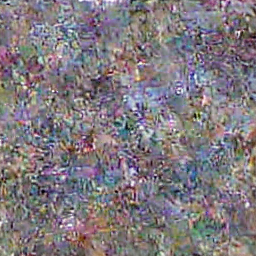

In [44]:
x_samples_ddim = student.decode_first_stage(student_intermediate["x_inter"][-1])
x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)
grid = rearrange(x_samples_ddim, 'b c h w -> (b) c h w')
grid = make_grid(grid, nrow=1)
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8)) 

In [ ]:
# state_teacher = sampler_teacher.model.state_dict().__str__()
# state_student = sampler_student.model.state_dict().__str__()

# print("sampler teacher equals student:", state_teacher == state_student)

# state_teacher = teacher.state_dict().__str__()
# state_student = student.state_dict().__str__()

# print("teacher equals student:", state_teacher == state_student)
# del state_teacher
# del state_student

sampler teacher equals student: True
teacher equals student: True


In [ ]:
sampler_teacher.model.state_dict()["model.diffusion_model.input_blocks.1.0.in_layers.0.weight"]

tensor([0.8373, 0.7964, 0.8032, 0.8130, 0.7707, 0.8521, 0.8578, 0.8658, 0.7949,
        0.7619, 0.7391, 0.8284, 0.8322, 0.6972, 0.7173, 0.8031, 0.8893, 0.8702,
        0.8415, 0.8149, 0.8227, 0.7373, 0.8765, 0.7965, 0.8394, 0.8689, 0.8407,
        0.8265, 0.7618, 0.8703, 0.8566, 0.8665, 0.8735, 0.7938, 0.8074, 0.7962,
        0.7656, 0.8333, 0.7913, 0.8476, 0.7907, 0.7734, 0.8171, 0.8681, 0.8451,
        0.8496, 0.8768, 0.8149, 0.9310, 0.8243, 0.7753, 0.7622, 0.6786, 0.8582,
        0.8255, 0.7970, 0.8167, 0.8767, 0.8667, 0.8351, 0.8524, 0.8102, 0.8485,
        0.8267, 0.8940, 0.8318, 0.8393, 0.8130, 0.8432, 0.8535, 0.9030, 0.8353,
        0.8459, 0.8236, 0.6624, 0.8795, 0.8267, 0.7779, 0.8151, 0.8713, 0.7678,
        0.8352, 0.7896, 0.8068, 0.8145, 0.8714, 0.7603, 0.8214, 0.8098, 0.8944,
        0.8118, 0.8701, 0.8704, 0.8569, 0.8372, 0.8222, 0.8360, 0.7996, 0.7751,
        0.6230, 0.7669, 0.8400, 0.8072, 0.8441, 0.6945, 0.8321, 0.8476, 0.7863,
        0.8149, 0.7795, 0.8045, 0.7803, 

In [40]:
student.model.requires_grad = True
student.model.state_dict()["diffusion_model.middle_block.1.transformer_blocks.0.attn1.to_k.weight"]

tensor([[ 0.0301, -0.0067,  0.0129,  ..., -0.0374,  0.0318,  0.0501],
        [ 0.0256,  0.0341, -0.0073,  ...,  0.0139,  0.0020, -0.0004],
        [ 0.0216, -0.0021, -0.0087,  ..., -0.0067, -0.0189, -0.0189],
        ...,
        [-0.0171,  0.0063, -0.0063,  ...,  0.0088,  0.0052, -0.0181],
        [-0.0076,  0.0068, -0.0104,  ..., -0.0135, -0.0250, -0.0060],
        [-0.0336,  0.0177,  0.0130,  ..., -0.0027,  0.0162,  0.0131]],
       device='cuda:0')

In [41]:
teacher.model.state_dict()["diffusion_model.middle_block.1.transformer_blocks.0.attn1.to_k.weight"]

NameError: name 'teacher' is not defined

In [42]:
sampler_student.model.requires_grad = True
sampler_student.model.state_dict()["model.diffusion_model.input_blocks.1.0.in_layers.0.weight"]

tensor([0.8373, 0.7964, 0.8032, 0.8130, 0.7707, 0.8521, 0.8578, 0.8658, 0.7949,
        0.7619, 0.7391, 0.8284, 0.8322, 0.6972, 0.7173, 0.8031, 0.8893, 0.8702,
        0.8415, 0.8149, 0.8227, 0.7373, 0.8765, 0.7965, 0.8394, 0.8689, 0.8407,
        0.8265, 0.7618, 0.8703, 0.8566, 0.8665, 0.8735, 0.7938, 0.8074, 0.7962,
        0.7656, 0.8333, 0.7913, 0.8476, 0.7907, 0.7734, 0.8171, 0.8681, 0.8451,
        0.8496, 0.8768, 0.8149, 0.9310, 0.8243, 0.7753, 0.7622, 0.6786, 0.8582,
        0.8255, 0.7970, 0.8167, 0.8767, 0.8667, 0.8351, 0.8524, 0.8102, 0.8485,
        0.8267, 0.8940, 0.8318, 0.8393, 0.8130, 0.8432, 0.8535, 0.9030, 0.8353,
        0.8459, 0.8236, 0.6624, 0.8795, 0.8267, 0.7779, 0.8151, 0.8713, 0.7678,
        0.8352, 0.7896, 0.8068, 0.8145, 0.8714, 0.7603, 0.8214, 0.8098, 0.8944,
        0.8118, 0.8701, 0.8704, 0.8569, 0.8372, 0.8222, 0.8360, 0.7996, 0.7751,
        0.6230, 0.7669, 0.8400, 0.8072, 0.8441, 0.6945, 0.8321, 0.8476, 0.7863,
        0.8149, 0.7795, 0.8045, 0.7803, 

In [ ]:
sampler_teacher.model.state_dict()["model.diffusion_model.input_blocks.1.0.in_layers.0.weight"]

tensor([0.8373, 0.7964, 0.8032, 0.8130, 0.7707, 0.8521, 0.8578, 0.8658, 0.7949,
        0.7619, 0.7391, 0.8284, 0.8322, 0.6972, 0.7173, 0.8031, 0.8893, 0.8702,
        0.8415, 0.8149, 0.8227, 0.7373, 0.8765, 0.7965, 0.8394, 0.8689, 0.8407,
        0.8265, 0.7618, 0.8703, 0.8566, 0.8665, 0.8735, 0.7938, 0.8074, 0.7962,
        0.7656, 0.8333, 0.7913, 0.8476, 0.7907, 0.7734, 0.8171, 0.8681, 0.8451,
        0.8496, 0.8768, 0.8149, 0.9310, 0.8243, 0.7753, 0.7622, 0.6786, 0.8582,
        0.8255, 0.7970, 0.8167, 0.8767, 0.8667, 0.8351, 0.8524, 0.8102, 0.8485,
        0.8267, 0.8940, 0.8318, 0.8393, 0.8130, 0.8432, 0.8535, 0.9030, 0.8353,
        0.8459, 0.8236, 0.6624, 0.8795, 0.8267, 0.7779, 0.8151, 0.8713, 0.7678,
        0.8352, 0.7896, 0.8068, 0.8145, 0.8714, 0.7603, 0.8214, 0.8098, 0.8944,
        0.8118, 0.8701, 0.8704, 0.8569, 0.8372, 0.8222, 0.8360, 0.7996, 0.7751,
        0.6230, 0.7669, 0.8400, 0.8072, 0.8441, 0.6945, 0.8321, 0.8476, 0.7863,
        0.8149, 0.7795, 0.8045, 0.7803, 

In [ ]:
student.requires_grad

True

In [ ]:
grid = torch.stack(teacher_samples)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=inst_per_distil * 2)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))

RuntimeError: stack expects a non-empty TensorList

In [ ]:
[b, c, h, w] = teacher_intermediate["x_inter"][-1].shape

In [ ]:
test = teacher_intermediate["x_inter"][-1]

test.flatten()

tensor([-0.1402, -0.9249, -0.4762,  ...,  0.7701,  1.1147,  1.7933],
       device='cuda:0')

In [ ]:
all_samples

[]

# That stuff not working, so saving images first:

In [ ]:
# import copy

# teacher = get_model(teacher=True)
# sampler_teacher = DDIMSampler(teacher)


In [ ]:
# import pandas as pd

# NUM_CLASSES = 1000
# generations = 1
# ddim_steps_teacher = 32
# TEACHER_STEPS = 2
# ddim_eta = 0.0
# scale = 3.0
# updates = int(ddim_steps_teacher / TEACHER_STEPS)

# all_samples = list()
# teacher_samples = list()

# classes = []
# conditioning = []
# intermediates = []
# x_ts = []

# with torch.no_grad():
#         with teacher.ema_scope():
#                 uc = teacher.get_learned_conditioning(
#                         {teacher.cond_stage_key: torch.tensor(1*[1000]).to(teacher.device)}
#                         )
#                 for class_prompt in torch.randint(0, NUM_CLASSES, (generations,)):

#                         sampler_teacher.make_schedule(ddim_num_steps=ddim_steps_teacher, ddim_eta=ddim_eta, verbose=False)
#                         xc = torch.tensor([class_prompt])
#                         c = teacher.get_learned_conditioning({teacher.cond_stage_key: xc.to(teacher.device)})
#                         x_T = None
                     
#                         for steps in range(updates):
                                
                                
#                                 # with torch.no_grad():
#                                 print("step:", steps)
                                
#                                 samples_ddim, teacher_intermediate, x_T_copy = sampler_teacher.sample(S=TEACHER_STEPS,
#                                                                 conditioning=c,
#                                                                 batch_size=1,
#                                                                 shape=[3, 64, 64],
#                                                                 verbose=False,
#                                                                 x_T=x_T,
#                                                                 unconditional_guidance_scale=scale,
#                                                                 unconditional_conditioning=uc, 
#                                                                 eta=ddim_eta,
#                                                                 keep_intermediates=True,
#                                                                 intermediate_step = steps*TEACHER_STEPS,
#                                                                 steps_per_sampling = TEACHER_STEPS,
#                                                                 total_steps = ddim_steps_teacher)
#                                 x_T = teacher_intermediate["x_inter"][-1]

#                                 x_ts.append(x_T_copy)
#                                 intermediates.append(x_T)
#                                 classes.append(xc)
#                                 conditioning.append(c)

#                                         with torch.enable_grad():
                                                
#                                                 if steps == 0:
                                                        
#                                                         x_T_student = copy.deepcopy(x_T_copy)
#                                                         x_T_student.requires_grad = True
                                                        
#                                                 optimizer.zero_grad()
#                                                 samples_ddim_student, student_intermediate, x_T_copy = sampler_student.sample_student(S=STUDENT_STEPS,
#                                                                                 conditioning=c_student,
#                                                                                 batch_size=1,
#                                                                                 shape=[3, 64, 64],
#                                                                                 verbose=False,
#                                                                                 x_T=x_T_student,
#                                                                                 unconditional_guidance_scale=scale,
#                                                                                 unconditional_conditioning=uc, 
#                                                                                 eta=ddim_eta,
#                                                                                 keep_intermediates=True,
#                                                                                 intermediate_step = steps*STUDENT_STEPS,
#                                                                                 steps_per_sampling = STUDENT_STEPS,
#                                                                                 total_steps = ddim_steps_student)
                                                
#                                                 x_T_student = student_intermediate["x_inter"][-1]
                                        
                                                
                                                
                                                
#                                                 # x_T_student.requires_grad = True
#                                                 # loss = mse_loss(x_T_student, x_T)
#                                                 loss = MSEloss(x_T_student, x_T)
#                                                 # loss = MSEloss(samples_ddim_student.flatten(), samples_ddim.flatten())
                                                
#                                                 print("Loss:", round(loss.item(), 5), end= " | ")
#                                                 print("loss", loss)
#                                                 print("backward!")
#                                                 loss.backward()
                                                
#                                                 optimizer.step()
                                                
#                                                 losses.append(loss.item())
#                                                 # optimizer.zero_grad()

In [ ]:
# torch.save(x_ts, "x_ts.pt")
# torch.save(classes, "classes.pt")
# torch.save(conditioning, "conditioning.pt")
# torch.save(intermediates, "intermediates.pt")

# Training student on saved images (fails for the same reason)

In [ ]:
student = get_model(teacher=False)
sampler_student = DDIMSampler(student)

Loading model from d:\OneDrive\Uni\Master_Project_AI\Code\Diffusion_Thesis\cin_256/model_student.ckpt


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [ ]:
# def mse_loss(teacher, student):
#     [b, c, h, w] = teacher.shape
#     size = c * h * w
#     teacher = teacher.flatten()
#     student = student.flatten()
#     return torch.sum((teacher - student) ** 2) / size

# MSEloss = nn.MSELoss()
# # torch.set_grad_enabled(True)
    

In [ ]:
# x_ts = torch.load("x_ts.pt")
# classes = torch.load("classes.pt")
# conditioning = torch.load("conditioning.pt")
# intermediates = torch.load("intermediates.pt")



In [ ]:
# NUM_CLASSES = 1000
# inst_per_distil = 1
# generations = 1
# ddim_steps_teacher = 32
# ddim_steps_student = 16
# TEACHER_STEPS = 2
# STUDENT_STEPS = 1
# ddim_eta = 0.0
# scale = 3.0

# updates = int(ddim_steps_teacher / TEACHER_STEPS)

# all_samples = list()
# averaged_losses = []

# teacher_samples = list()
# student_samples = list()

# losses = []

# optimizer = torch.optim.Adam(sampler_student.model.parameters(), lr=0.00001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
# # optimizer = torch.optim.SGD(sampler_student.model.parameters(), lr=0.0001, momentum=0.9)


# with torch.enable_grad():
#     with student.ema_scope():
#             uc = student.get_learned_conditioning(
#                     {student.cond_stage_key: torch.tensor(1*[1000]).to(student.device)}
#                     )
#             for i in range(len(classes)):
                    
#                     sampler_student.make_schedule(ddim_num_steps=ddim_steps_student, ddim_eta=ddim_eta, verbose=False)
#                     xc = torch.tensor([classes[i]])
#                     c = conditioning[i]
#                     for steps in range(16):
#                         optimizer.zero_grad()
                        
#                         x_T = x_ts[i]
#                         x_T.requires_grad = True
                            

                        
                                        

#                         samples_ddim_student, student_intermediate, x_T_copy = sampler_student.sample_student(S=STUDENT_STEPS,
#                                                 conditioning=c,
#                                                 batch_size=1,
#                                                 shape=[3, 64, 64],
#                                                 verbose=False,
#                                                 x_T=x_T,
#                                                 unconditional_guidance_scale=scale,
#                                                 unconditional_conditioning=uc, 
#                                                 eta=ddim_eta,
#                                                 keep_intermediates=True,
#                                                 intermediate_step = steps*STUDENT_STEPS,
#                                                 steps_per_sampling = STUDENT_STEPS,
#                                                 total_steps = ddim_steps_student)
                                
                        
                        
                                
                        
#                         loss = MSEloss(student_intermediate["x_inter"][-1], intermediates[i])                               
#                         print("Loss:", round(loss.item(), 5), end= " | ")
#                         print("loss", loss)
#                         print("backward!")
#                         loss.backward()
#                         optimizer.step()
#                         student_intermediate["x_inter"][-1].detach()
#                         losses.append(loss.item())
#                         # optimizer.zero_grad()
                
                            

#             print("Loss: ", round(sum(losses) / len(losses), 5), end= " - ")
#             averaged_losses.append(sum(losses) / len(losses))


#             x_samples_ddim = student.decode_first_stage(x_T)
#             x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)
#             teacher_samples.append(x_samples_ddim)
                                            

# plt.plot(range(len(averaged_losses)), averaged_losses, label="MSE LOSS")
# plt.xlabel("Generations")
# plt.ylabel("px MSE")
# plt.title("MSEloss student vs teacher")
# plt.show()

Loss: 7e-05 | loss tensor(7.4097e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
backward!
Loss: 1e-05 | loss tensor(1.3562e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
backward!


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

tensor([[[-3.0897e-01, -8.1357e-01, -4.6836e-01, -1.0647e-02,  5.6398e-01,
          -2.7529e-01, -8.6408e-01,  2.4275e-01,  3.1143e-01,  1.4782e+00,
          -2.7091e-01,  8.9683e-01, -1.1368e+00, -5.1967e-01,  5.1754e-02,
          -8.0823e-01, -5.4126e-01,  4.1333e-01, -1.8092e-01, -1.0548e+00,
           1.3068e+00,  2.5801e-02,  8.1891e-01, -7.3705e-01, -1.1790e+00,
           5.5735e-01,  1.5229e+00,  1.7481e-01, -5.5413e-02,  4.0618e-01,
          -7.4052e-01, -8.5432e-01,  5.5856e-01, -1.4511e-01,  1.0961e+00,
           1.1619e-01, -1.3935e-01,  6.0510e-02, -4.0981e-01, -4.8484e-01,
           4.3703e-01,  1.0501e-01, -3.3011e-01,  6.5664e-01, -4.3902e-01,
           1.3095e+00,  5.6454e-01, -1.1117e+00, -1.0756e+00,  4.0118e-01,
          -1.0922e+00, -8.2679e-01,  9.1757e-01, -9.3842e-01,  1.3343e-01,
          -1.2548e-01, -4.0816e-01, -1.0880e+00, -5.2834e-01, -3.8515e-01,
           4.5241e-01,  6.5101e-02,  4.2610e-01,  3.3078e-01, -8.5955e-01,
          -4.3450e-01, -1